In [21]:
# first make sure the input data are good 
import numpy as np 
import os 
import sys
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, make_scorer, f1_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_validate, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import shap
from utils.hyperopt_utils import get_best_hyperparameters
if sys.platform == 'darwin':
    print("Current system is macOS")
    main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
elif sys.platform == 'linux':
    print("Current system is Ubuntu")
    main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
else:
    print("Current system is neither macOS nor Ubuntu")
    
    
os.chdir(main_fold_path)

from utils.fnirs_utils import print_md_table_val_test_AUC

def derive_average_MMDR_score(input_fold, K_FOLD=5):
    all_X = []
    for i in range(1, 11):
        data_path = input_fold + f'/y_pred_loocv_v{i+3}.npy'
        X = np.mean(np.load(data_path).reshape(-1, K_FOLD, 2), axis=1)[:, 1:]
        all_X.append(X)
    all_X = np.array(all_X)
    all_X = np.mean(all_X, axis=0)
    return all_X

def replace_nan_with_mean(data):
    input = data.copy()
    for i in range(input.shape[1]):
        col = input[:, i]
        col = np.array(col, dtype=float)
        mean_value = np.nanmean(col)
        col[np.isnan(col)] = mean_value
        input[:, i] = col
    return input
def impute_nan_data(data):
    input = data.copy()
    from sklearn.experimental import enable_iterative_imputer
    # Now you can import IterativeImputer
    from sklearn.impute import IterativeImputer


    # Create an instance of IterativeImputer
    imputer = IterativeImputer()

    # Fit the imputer on the clinical_data ndarray
    imputer.fit(input)

    # Transform the clinical_data ndarray by imputing the NaN values
    imputed_data = imputer.transform(input)
    return imputed_data

def process_with_nan_using_imputation_zscore(data):
    data[data == 'missing data'] = np.nan
    data.astype(float)
    data = impute_nan_data(data)
    data = zscore(data, axis=0)
    return data

# CGI in T1 only has 1 value which is severity, so we delete them
def read_base_T2_SDS_CGI(fold_path):
    all_clinical = np.load(fold_path + '/CLINICAL_HISTORY.npy', allow_pickle=True)
    all_clinical_chosen_index = np.arange(0, 6).tolist() + np.arange(8, 16).tolist()
    all_clinical_chosen_index = np.array(all_clinical_chosen_index) 
    return all_clinical[:, all_clinical_chosen_index]


def read_pychiatry(fold_path):
    pyschiatry = np.load(fold_path + '/PSYCHIATRY_HISTORY.npy', allow_pickle=True)
    all_pyschiatry_chosen_index = np.arange(4).tolist() + np.arange(6, 15).tolist()
    all_pyschiatry_chosen_index = np.array(all_pyschiatry_chosen_index)
    return pyschiatry[:, all_pyschiatry_chosen_index]



def read_HAMD_score(fold_path):
    HAMD_ALL = np.load(fold_path + '/HAMD_ALL_HISTORY.npy', allow_pickle=True)
    HAMD_base_T2 = HAMD_ALL[:, :2]
    HAMD_reduction = (HAMD_ALL[:, 1] - HAMD_ALL[:, 0]) / HAMD_ALL[:, 0]
    HAMD_T1_T2_reduction = np.concatenate((HAMD_base_T2, HAMD_reduction[..., np.newaxis]), axis=1)
    return HAMD_T1_T2_reduction

def read_demographic(fold_path):
    demographic_data = np.load(fold_path + '/demographic.npy', allow_pickle=True)
    return demographic_data


# clinical_data = np.load(fold_path + '/baseline_clinical_data.npy', allow_pickle=True)
# demographic_data = np.load(fold_path + '/demografic_data.npy', allow_pickle=True)



def plot_avg_auc(fprs, tprs, roc_aucs, title):
    mean_fpr = np.linspace(0, 1, 100)

    # Interpolate TPRs at these common FPR levels
    mean_tpr = np.zeros_like(mean_fpr)
    tpr_interpolated = []

    for i in range(len(fprs)):
        tpr_interp = np.interp(mean_fpr, fprs[i], tprs[i])
        tpr_interpolated.append(tpr_interp)
        
        
    # Calculate the mean TPR
    tpr_interpolated = np.array(tpr_interpolated)
    mean_tpr = tpr_interpolated.mean(axis=0)
    std_tpr = tpr_interpolated.std(axis=0)

    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)

    # Compute AUC
    mean_auc = np.mean(roc_aucs) # auc(mean_fpr, mean_tpr)
    std_auc = np.std(roc_aucs)
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, lw=2, color='#000080', label='Mean ROC (AUC %0.2f ± %0.2f)' % (mean_auc, std_auc))
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3, label='±1 SD')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid()
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.legend(loc="lower right", frameon=False)

    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.show()
    
    
def train_xgboost_shuffle_feature(X, 
                                  Y, 
                                  model_name='XGBoost',
                                  num_shuffle=2, 
                                  msg="", 
                                  title="", 
                                  is_plotting_avg_auc=False, 
                                  is_shuffling=True,
                                  is_computing_shap=True,
                                  best_params_xgboost=None):
    scale = 1e6# for scale in [1e6]: # [1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]:
    

    model_dict = {
        'XGBoost': XGBClassifier(scale_pos_weight=scale, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(scale_pos_weight=5, verbose=0),
    }
    if best_params_xgboost is not None:
        best_params_xgboost = get_best_hyperparameters(X, Y, num_evals=200)
        model_dict['XGBoost'] = XGBClassifier(**best_params_xgboost)
        
    
    plt.figure(figsize=(10, 10))

    def specificity_score(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)
        return specificity

    def get_f1_score(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')
    
    # Create a scorer for specificity
    specificity_scorer = make_scorer(specificity_score)
    get_f1_scorer = make_scorer(get_f1_score)

    scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score),
                'sensitivity': make_scorer(recall_score),
                'specificity': specificity_scorer,
                'f1_score': get_f1_scorer,
                'AUC': make_scorer(roc_auc_score)}
    # Assuming X, Y, and a dictionary of models are already defined

    # Outer loop: Leave-One-Out Cross-Validation (LOOCV)
    loo = LeaveOneOut()

    X_tmp = X.copy()
    Y_tmp = Y.copy()

    fprs, tprs, roc_aucs = [], [], []
    shuffle_inner_fold = []
    shuffle_outer_fold = []
    if is_computing_shap: shuffle_all_shaps = []
    
    if not is_shuffling: num_shuffle = 1
    
    for shuffle_i in range(num_shuffle):
        
        y_pred_all = []
        results = {}
        all_inner_fold = []
        all_outer_fold = []
        all_shaps = []
        y_pred_prob_all = []

        # Shuffle X_tmp and Y_tmp
        if is_shuffling:
            shuffled_indices = np.random.permutation(X_tmp.shape[1])
        else:
            shuffled_indices = np.arange(X_tmp.shape[1])
        print(" shuffled_indices ", shuffled_indices)
            
        X_tmp_shuffled = X_tmp[:,shuffled_indices]
        Y_tmp_shuffled = Y_tmp#[shuffled_indices]

        # for model_name, model in models.items():
        # model_name = 'XGBoost'
        model = model_dict[model_name]
        

        for train_index, test_index in loo.split(X):
            # Splitting the dataset for this LOOCV iteration
            X_train, X_test = X_tmp_shuffled[train_index], X_tmp_shuffled[test_index]
            Y_train, Y_test = Y_tmp_shuffled[train_index], Y_tmp_shuffled[test_index]
            stratified_kfold = StratifiedKFold(n_splits=5)
            cv_results = cross_validate(model, X_train, Y_train, cv=stratified_kfold, scoring=scoring, return_train_score=False)
        
            # Calculate mean scores
            mean_accuracy = cv_results['test_balanced_accuracy'].mean()
            mean_sensitivity = cv_results['test_sensitivity'].mean()
            mean_specificity = cv_results['test_specificity'].mean()
            mean_AUC = cv_results['test_AUC'].mean()
            # m
            
            # Store the results
            results[model_name] = {'bAcc': mean_accuracy, 'Sensitivity': mean_sensitivity, 'Specificity': mean_specificity, 'AUC': mean_AUC}
            all_inner_fold.append([results[model_name]['bAcc'], results[model_name]['Sensitivity'], results[model_name]['Specificity'], results[model_name]['AUC']])
            # print('inner cv results', results[model_name])
            # Inner loop: 5-fold cross-validation for training and validating the model
            # Note: Adjustments might be needed depending on how you intend to use the results of inner CV for model selection or tuning
            
            # Train the model using the inner CV folds
            # Note: You might use cross_val_predict or another approach here for model selection or tuning
            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)

            probabilities = model.predict_proba(X_test)
            y_pred_prob_all.append(probabilities)
            y_pred_all.append(Y_pred)
            
            if is_computing_shap:
                # Create an explainer object
                explainer = shap.TreeExplainer(model)
                # Calculate SHAP values for all samples
                shap_values = explainer(X_test) 
                all_shaps.append(shap_values)

            # Assuming X, Y, and a trained XGBoost model are already defined        

        y_pred_ind = []
        for i in range(len(y_pred_all)):
            y_pred_ind.append(y_pred_all[i][0])


        
        f1 = f1_score(Y_tmp_shuffled, y_pred_ind, average='weighted')
        accuracy = accuracy_score(Y_tmp_shuffled, y_pred_ind)
        # Calculate sensitivity (recall)
        sensitivity = recall_score(Y_tmp_shuffled, y_pred_ind)  # This is already done in your snippet
        # Calculate specificity
        specificity = specificity_score(Y_tmp_shuffled, y_pred_ind)
        np_y_pred_prob_all = np.array([i[0] for i in y_pred_prob_all])

        fpr, tpr, _ = roc_curve(Y_tmp_shuffled, np_y_pred_prob_all[:, 1])
        roc_auc = auc(fpr, tpr)
        
        all_outer_fold = [accuracy, sensitivity, specificity, roc_auc]
        shuffle_outer_fold.append(all_outer_fold)
        print(f"num_of_shuffle {shuffle_i} scaled by {scale} Accuracy: {accuracy} Sensitivity is {sensitivity} Specificity is {specificity} AUC is {roc_auc}")

        fprs.append(fpr)
        tprs.append(tpr)
        roc_aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) } - random - %d' % (roc_auc, shuffle_i) + msg)

        all_inner_fold = np.array(all_inner_fold)
        all_inner_fold_mean = np.mean(all_inner_fold, axis=0)
        shuffle_inner_fold.append(all_inner_fold_mean)
        print(all_inner_fold_mean)
        

        if is_computing_shap: shuffle_all_shaps.append(all_shaps)
        
    # Plotting the ROC curve

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.legend(loc="lower right")
    
    if is_plotting_avg_auc:
        plot_avg_auc(fprs, tprs, roc_aucs, title)
    # plt.show()
    
    mean_shuffle_inner_fold = np.mean(shuffle_inner_fold, axis=0)
    mean_shuffle_outer_fold = np.mean(shuffle_outer_fold, axis=0)
    print_md_table_val_test_AUC(model_name, mean_shuffle_outer_fold, mean_shuffle_inner_fold)
    if is_computing_shap: return shuffle_all_shaps
    else: return None




Current system is macOS


In [10]:

fold_path = 'allData/prognosis_mix_hb/pretreatment_response'
MMDR_path = 'allData/prognosis_mix_hb/pretreatment_response/MDDR'

base_T2_SDS_CGI = read_base_T2_SDS_CGI(fold_path)
pyschiatry = read_pychiatry(fold_path)
HAMD_score = read_HAMD_score(fold_path)
demographic = read_demographic(fold_path)

pro_base_T2_SDS_CGI = process_with_nan_using_imputation_zscore(base_T2_SDS_CGI)
pro_pyschiatry = process_with_nan_using_imputation_zscore(pyschiatry)
print('pro_pyschiatry ->', pro_pyschiatry.shape)
pro_pyschiatry = np.concatenate((pro_pyschiatry[:, :-3], pro_pyschiatry[:, -2:]), axis=1) # must remove the -3rd column, because its existen will cause nan value of that column
pro_HAMD_score = process_with_nan_using_imputation_zscore(HAMD_score)
pro_demographic = process_with_nan_using_imputation_zscore(demographic)

K_FOLD = 5
MMDR_path = 'allData/prognosis_mix_hb/pretreatment_response/MDDR'
fnirs_feature = derive_average_MMDR_score(MMDR_path, K_FOLD=K_FOLD)
fnirs_feature = derive_average_MMDR_score(MMDR_path) # np.mean(np.load(MMDR_path + '/y_pred_loocv_v4.npy').reshape(-1, K_FOLD, 2), axis=1)[:, 1:]
# fnirs_feature_path_1 = fold_path + '/fnirs_pred_loocv1.npy'
# fnirs_feature_path_2 = fold_path + '/fnirs_pred_loocv2.npy'
# fnirs_feature_path_3 = fold_path + '/fnirs_pred_loocv3.npy'
# fnirs_feature_path_4 = fold_path + '/fnirs_pred_loocv4.npy'
# fnirs_prediction_all = []
# for path in [fnirs_feature_path_1, fnirs_feature_path_2, fnirs_feature_path_4]: #[fnirs_feature_path_3]: #[fnirs_feature_path_1, fnirs_feature_path_2, fnirs_feature_path_4]:

#     fnirs_pred = np.load(path, allow_pickle=True)

#     y_pred = np.reshape(fnirs_pred, (-1, K_FOLD, 2))
#     fnirs_feature = np.mean(y_pred, axis=1)[:, 1:]
#     fnirs_prediction_all.append(fnirs_feature)
    
# fnirs_prediction_all = np.concatenate(fnirs_prediction_all, axis=1)

Y = np.load(fold_path + '/label.npy', allow_pickle=True)



pro_pyschiatry -> (64, 13)


In [22]:
from hyperopt import space_eval
from hyperopt import hp
# for i in range(pro_pyschiatry.shape[1]):
X_data = np.concatenate((pro_pyschiatry[:,:9], pro_demographic, fnirs_feature), axis=1)
best_parameters_is = {'alpha': 0.13910979787620678, 'gamma': 0.3329388667739047, 'lambda': 1.4933874399358753, 'learning_rate': 0.40421787263977055, 'max_depth': 11, 'min_child_weight': 1.5614016831327424, 'n_estimators': 223, 'scale_pos_weight': 2693.3462547957015}
space = {
        'learning_rate': hp.loguniform('learning_rate', -6.907755278982137, 0), # loguniform for 0.001 to 1
        'min_child_weight': hp.uniform('min_child_weight', 0.8, 2.0),
        'max_depth': hp.choice('max_depth', range(3, 16)),
        'gamma': hp.uniform('gamma', 0.0, 2.0),
        'lambda': hp.uniform('lambda', 0.0, 4.0),
        'alpha': hp.uniform('alpha', 0.0, 2.0),
        'n_estimators': hp.choice('n_estimators', range(50, 301)),
        'scale_pos_weight': hp.loguniform('scale_pos_weight', np.log(1), np.log(1e8)),
    }
best_params = space_eval(space, best_parameters_is)


# X_data = fnirs_feature
shuffle_all_shaps = train_xgboost_shuffle_feature(X_data, 
                                                  Y, 
                                                  model_name='XGBoost',
                                                  num_shuffle=10, 
                                                  title=f"Treatment Response Prediction (fNIRS + demographic and psychiatric feature) ", 
                                                  is_plotting_avg_auc=True, 
                                                  is_shuffling=True, 
                                                  is_computing_shap=False,
                                                  best_params_xgboost=best_params)


  9%|▉         | 18/200 [02:17<23:14,  7.66s/trial, best loss: -0.5065909090909091]


KeyboardInterrupt: 

In [11]:
for i in range(4,14):
    fnirs_feature = np.mean(np.load(MMDR_path + f'/y_pred_loocv_v{i}.npy').reshape(-1, K_FOLD, 2), axis=1)[:, 1:]
    # for i in range(pro_pyschiatry.shape[1]):
    X_data = np.concatenate((pro_pyschiatry[:,:9], pro_demographic, fnirs_feature), axis=1)
    np.save('/Users/shanxiafeng/Documents/Code/learning/learn_hypderopt/input/data_{}.npy'.format(i-3), X_data)
    # X_data = fnirs_feature
    # shuffle_all_shaps = train_xgboost_shuffle_feature(X_data, Y, model_name='XGBoost', num_shuffle=10, title=f"(I={i-3})Treatment Response Prediction (fNIRS + demographic and psychiatric feature) ", is_plotting_avg_auc=False, is_shuffling=False, is_computing_shap=False)


Correlation coefficient (r): -0.2284404756062832
P-value: 0.06943263932219333


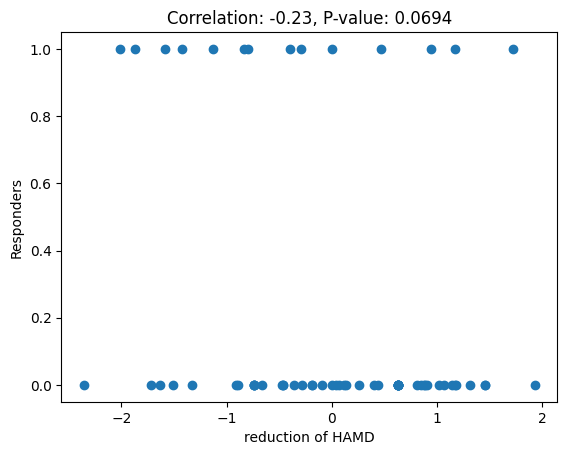

In [35]:
plt.figure()
untreated_month = data[:, i]

correlation, p_value = pearsonr(pro_HAMD_score[:,2], Y)
print("Correlation coefficient (r):", correlation)
print("P-value:", p_value)

plt.scatter(pro_HAMD_score[:,2], Y)
plt.title(f"Correlation: {correlation:.2f}, P-value: {p_value:.4f}")
plt.xlabel("reduction of HAMD")
plt.ylabel("Responders")
plt.show()


In [22]:
import numpy as np
reduction = HAMD_score[:, 2] 

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

psychiatric_history_name = ['Past trauma', 
                        'Current psychiatric comorbidities', 
                        'Current psychiatric comorbidities',
                        'Family history of psychiatric illness',
                        'Age of depression onset (years)',
                        'Duration of depression (years)',
                        'Duration of untreated depression (months)',
                        'Past EmD visit(s) because of depression',
                        'Type of episode']
demographic_name = ['Age', 'Gender', 'Ethnicity', 'Handedness', 'Education years', 'Education level', 'Perceived social support']
fnirs_name = ['MDDR']


data = pro_demographic
name = demographic_name 
for i in range(data.shape[1]):
    plt.figure()
    untreated_month = data[:, i]

    correlation, p_value = pearsonr(untreated_month, reduction)
    print("Correlation coefficient (r):", correlation)
    print("P-value:", p_value)

    plt.scatter(untreated_month, reduction)
    plt.title(f"Correlation: {correlation:.2f}, P-value: {p_value:.4f}, name: {name[i]}")
    plt.xlabel("Untreated Month")
    plt.ylabel("HAMD Reduction")
    plt.show()



ValueError: array must not contain infs or NaNs

<Figure size 640x480 with 0 Axes>

In [9]:
pro_pyschiatry.shape

(64, 12)

 shuffled_indices  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


[16:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[16:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[16:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[16:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[16:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: 

num_of_shuffle 0 scaled by 1000000.0 Accuracy: 0.640625 Sensitivity is 0.7142857142857143 Specificity is 0.62 AUC is 0.7185714285714285
[0.63092014 0.640625   0.62121528 0.63092014]


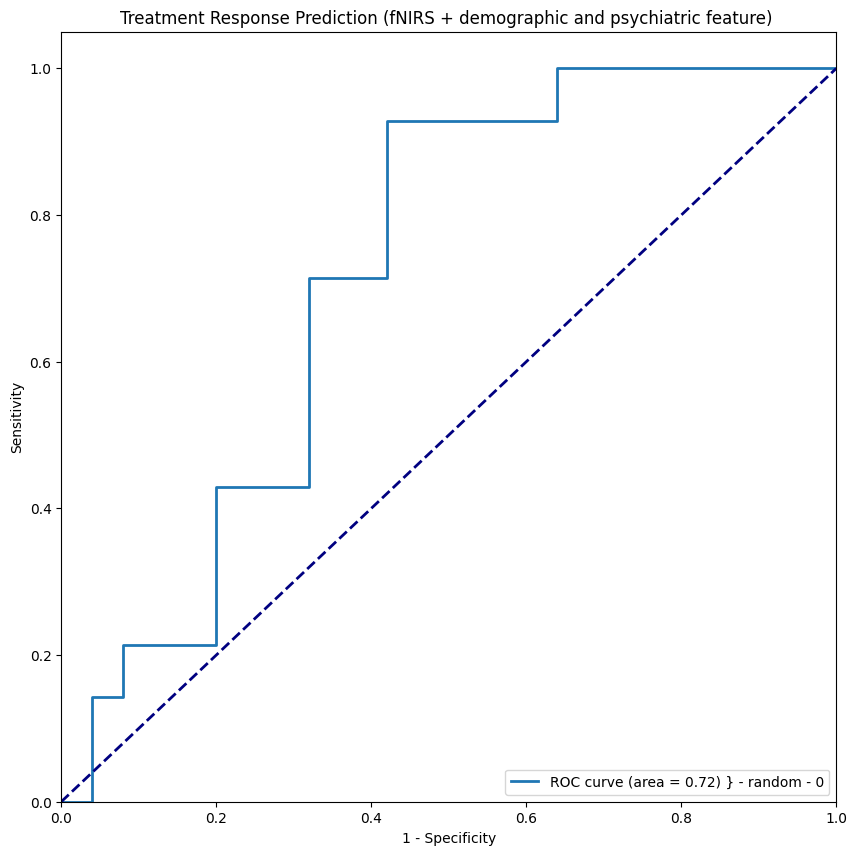

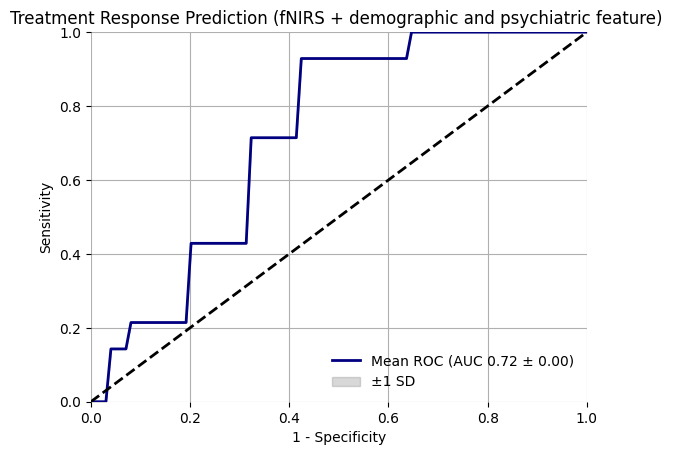

| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
|            | Balanced Accuracy | Sensitivity | Specificity | AUC | Balanced Accuracy | Sensitivity | Specificity | AUC |
| XGBoost   | 66.7143  | 71.4286  | 62.0000  | 71.8571  | 63.0920  | 64.0625  | 62.1215  | 63.0920  |

In [ ]:
import shap
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
print(X_display)

In [451]:

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Create a scorer for specificity
specificity_scorer = make_scorer(specificity_score)

X_train = X_data[:, -1:]
Y_train = Y
models = {
    #'CatBoost': CatBoostClassifier(scale_pos_weight=12, verbose=0),
    'XGBoost': XGBClassifier(scale_pos_weight=61 * 1e5),
    'RandomForest': RandomForestClassifier(n_estimators=200, bootstrap=False, min_samples_leaf=10, class_weight='balanced', max_depth=20),
    'DecisionTree': DecisionTreeClassifier(max_depth=190, criterion='log_loss', splitter='random', class_weight="balanced"),
    'Support Vector': SVC(kernel='linear', probability=False, class_weight={0:1, 1:61e5}, C=1e4),
    'NearestNeighbor': KNeighborsClassifier(),
    'Perceptron': Perceptron()
}


results = {}

for model_name, model in models.items():
    # Define the scorers you want to use
    scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score),
               'sensitivity': make_scorer(recall_score),
                'specificity': specificity_scorer}
    
    # Perform 5-fold cross-validation and get the results
    cv_results = cross_validate(model, X_train, Y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Calculate mean scores
    mean_accuracy = cv_results['test_balanced_accuracy'].mean()
    mean_sensitivity = cv_results['test_sensitivity'].mean()
    mean_specificity = cv_results['test_specificity'].mean()
    
    # Store the results
    results[model_name] = {'bAcc': mean_accuracy, 'Sensitivity': mean_sensitivity, 'Specificity': mean_specificity}
    print(f"model - {model_name} - metrics - {results[model_name]}")

model - XGBoost - metrics - {'bAcc': 0.6566666666666666, 'Sensitivity': 0.7333333333333333, 'Specificity': 0.58}
model - RandomForest - metrics - {'bAcc': 0.6466666666666667, 'Sensitivity': 0.7333333333333333, 'Specificity': 0.5599999999999999}
model - DecisionTree - metrics - {'bAcc': 0.5533333333333335, 'Sensitivity': 0.36666666666666664, 'Specificity': 0.74}
model - Support Vector - metrics - {'bAcc': 0.5, 'Sensitivity': 1.0, 'Specificity': 0.0}
model - NearestNeighbor - metrics - {'bAcc': 0.5900000000000001, 'Sensitivity': 0.3, 'Specificity': 0.8800000000000001}
model - Perceptron - metrics - {'bAcc': 0.5333333333333333, 'Sensitivity': 0.26666666666666666, 'Specificity': 0.8}


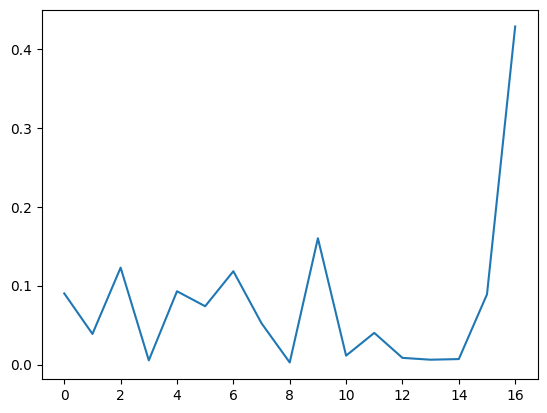

In [7]:
shap_values = []
shap_base_values = []
for i in range(1):
    for j in range(64):
            shap_v = []
            shap_b = []
            for k in range(17):  
                shap_v.append(shuffle_all_shaps[i][j][0][k].values)
                shap_b.append(shuffle_all_shaps[i][j][0][k].base_values)
            shap_values.append(shap_v)
            shap_base_values.append(shap_b)

shap_values = np.array(shap_values) / np.max(np.abs(shap_values))
shap_base_values = np.array(shap_base_values) 


minus_value = shap_values + shap_base_values  
# print(minus_value.shape)
plt.plot(np.mean(np.abs(shap_values), axis=0))

In [8]:
psychiatric_history_name = ['Past trauma', 
                        'Current psychiatric comorbidities', 
                        'Current psychiatric comorbidities',
                        'Family history of psychiatric illness',
                        'Age of depression onset (years)',
                        'Duration of depression (years)',
                        'Duration of untreated depression (months)',
                        'Past EmD visit(s) because of depression',
                        'Type of episode']
demographic_name = ['Age', 'Gender', 'Ethnicity', 'Handedness', 'Education years', 'Education level', 'Perceived social support']
fnirs_name = ['MDDR']


x_input_name = psychiatric_history_name + demographic_name + fnirs_name

print(len(x_input_name))

17


In [64]:
shap_values = shap_values / np.max(shap_values)

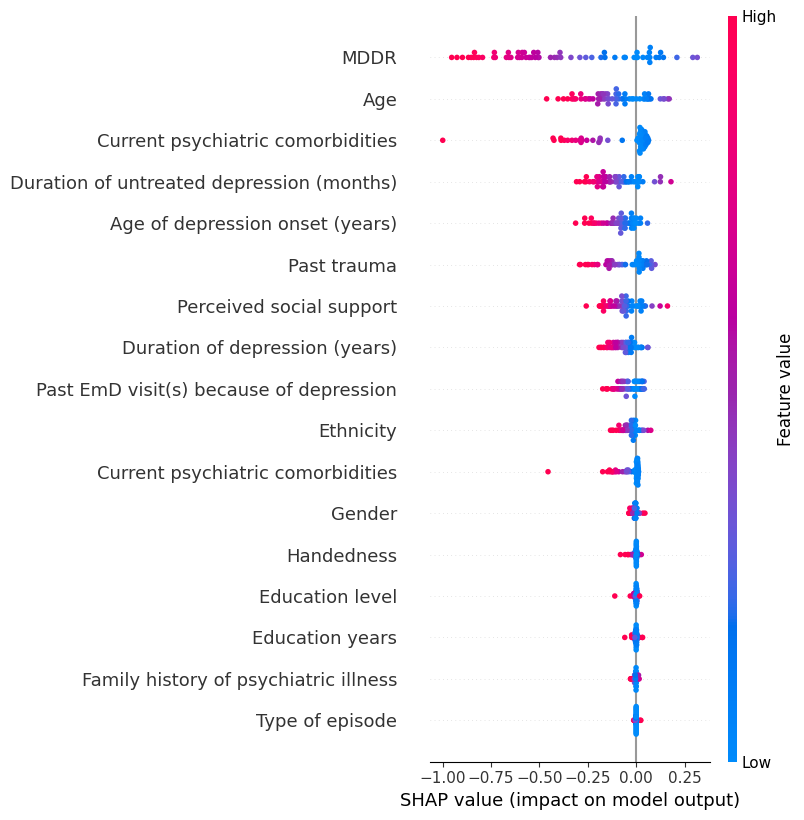

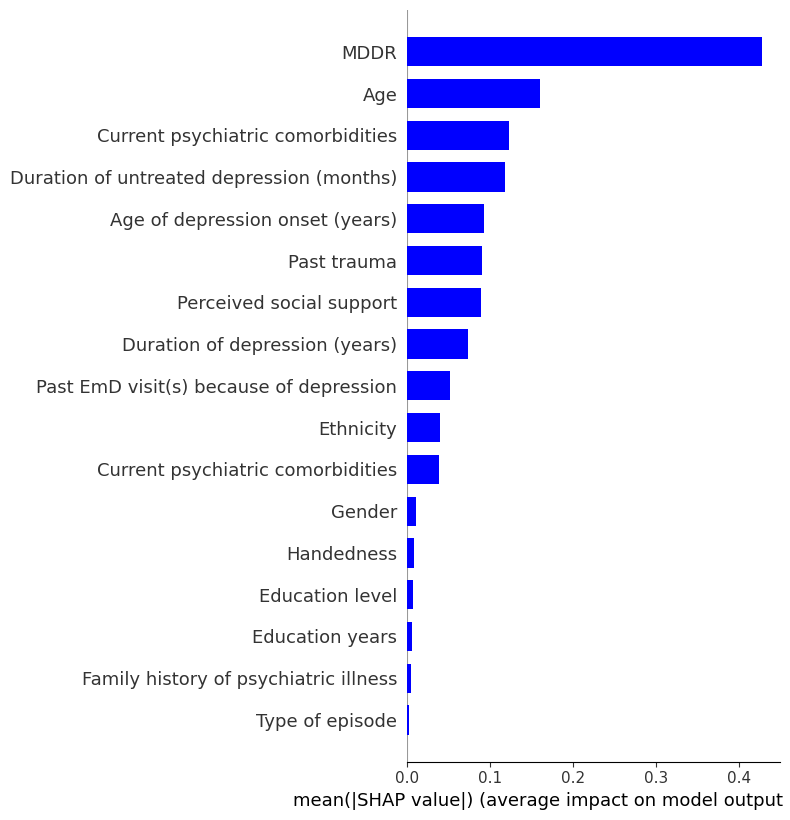

In [9]:
shap.summary_plot(shap_values, features=np.abs(shap_values), feature_names=x_input_name)
shap.summary_plot(shap_values, features=np.abs(shap_values), feature_names=x_input_name, plot_type='bar', color='blue')

# shap.plots.bar(shuffle_all_shaps[0][0][0])

In [38]:

np_shuffle_all_shaps = np.array(shuffle_all_shaps)

In [44]:
combined_shap_values = []
for i in range(64):
    combined_shap_values.append(shuffle_all_shaps[0][i][0].values)
combined_shap_values = np.array(combined_shap_values)    

base_values = shuffle_all_shaps[0][0][0].base_values
data = shuffle_all_shaps[0][0][0].data


In [304]:

# fnirs_prediction_all = fnirs_prediction_all[:, -1:]
# print(fnirs_prediction_all.shape)


<function auc at 0x13f134700>
<function auc at 0x13f134700>
<function auc at 0x13f134700>
[array([0.  , 0.02, 0.02, 0.04, 0.04, 0.24, 0.24, 0.36, 0.36, 0.82, 0.82,
       0.84, 0.84, 0.88, 0.88, 0.9 , 0.9 , 0.94, 0.94, 1.  ]), array([0.  , 0.  , 0.04, 0.04, 0.06, 0.06, 0.12, 0.12, 0.24, 0.24, 0.56,
       0.56, 0.76, 0.76, 0.78, 0.78, 0.82, 0.82, 1.  , 1.  ]), array([0.  , 0.02, 0.02, 0.06, 0.06, 0.08, 0.08, 0.1 , 0.1 , 0.14, 0.14,
       0.4 , 0.4 , 0.7 , 0.7 , 0.8 , 0.8 , 0.94, 0.94, 0.96, 0.96, 0.98,
       0.98, 1.  ])]


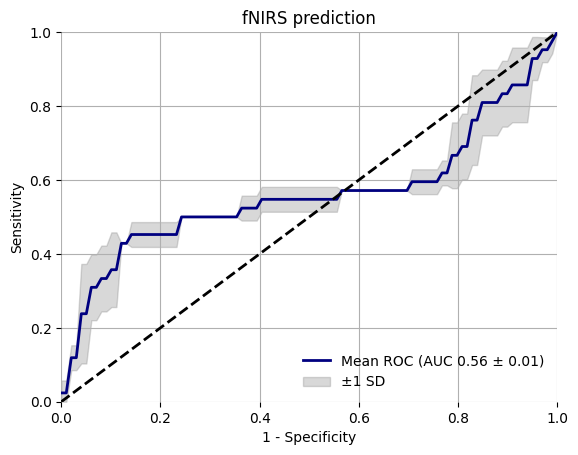

In [147]:
fprs, tprs, aucs = [], [], []
for i in range(3):
    y_pred = fnirs_prediction_all[:, i]
    fpr, tpr, _ = roc_curve(Y, y_pred)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % auc)
    print(auc)
    
print(fprs)

plot_avg_auc(fprs, tprs, aucs, 'fNIRS prediction')

In [1]:
print("Hello")

Hello


scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5714285714285714 Specificity is 0.62 AUC is 0.6585714285714286
[0.69583333 0.69947917 0.6921875 ]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6542857142857142
[0.68329861 0.69166667 0.67493056]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5 Specificity is 0.64 AUC is 0.6642857142857143
[0.69039931 0.70416667 0.67663194]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6614285714285715
[0.68909722 0.69791667 0.68027778]
scaled by 1000000.0 Accuracy: 0.625 Sensitivity is 0.5 Specificity is 0.66 AUC is 0.6585714285714286
[0.69578125 0.7        0.6915625 ]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6642857142857143
[0.68491319 0.69479167 0.67503472]
scaled by 1000000.0 Accuracy: 0.625 Sensitivity is 0.5714285714285714 Specificity is 0.64 AUC is 0.6628571428571428
[0.69770833 0.70260417 0.6928125 ]
scaled

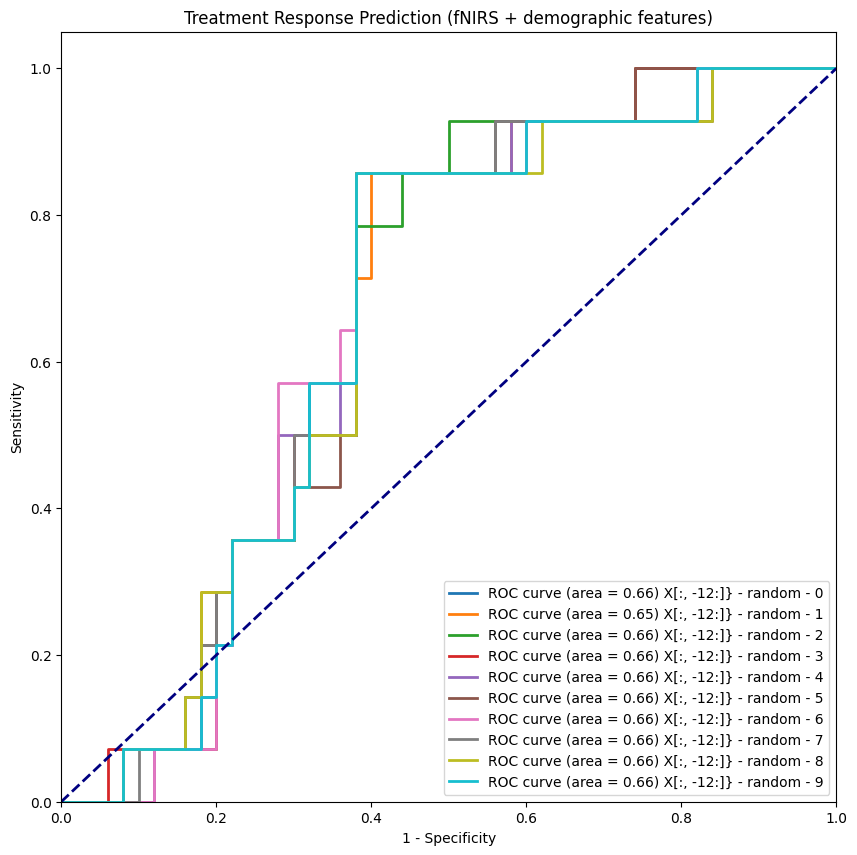

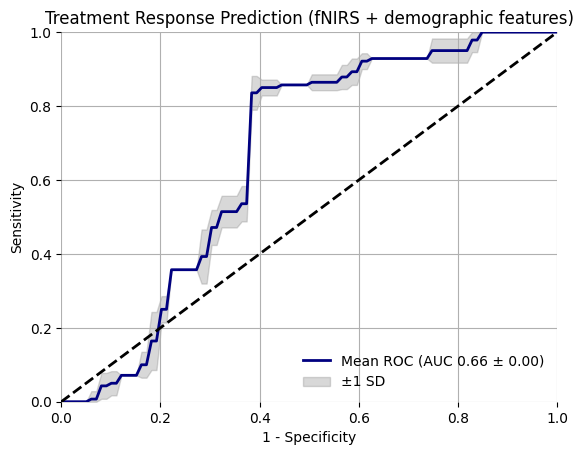

In [ ]:
acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=10, title="Treatment Response Prediction (fNIRS + demographic features)", is_plotting_avg_auc=True)


In [5]:


mean_clinical_data = replace_nan_with_mean(clinical_data)
imputed_clinical_data = impute_nan_data(clinical_data)
z_imputed_clinical_data = zscore(imputed_clinical_data, axis=0)

# add MMDT data

demographic_data = demographic_data.astype(float)
demographic_data = impute_nan_data(demographic_data)
demographic_data = zscore(demographic_data, axis=0)

In [27]:

# plt.figure()
# plt.imshow(pro_base_T2_SDS_CGI, aspect='auto')
# plt.figure()
# plt.imshow(pro_pyschiatry, aspect='auto')
# plt.figure()
# plt.imshow(pro_HAMD_score, aspect='auto')
# plt.figure()
# plt.imshow(pro_demographic, aspect='auto')




clinical_data = np.concatenate((pro_base_T2_SDS_CGI, pro_pyschiatry, pro_HAMD_score), axis=1)



In [ ]:
num_features = clinical_data.shape[1]

best_sen = 0
best_selected_features_indices = None
Y = np.load(fold_path + '/label.npy', allow_pickle=True)


# while True:
#     num_selected_feature = np.random.randint(1, num_features)
#     selected_features_indices = np.random.choice(num_features, size=num_selected_feature, replace=False)
#     selected_clinical_data = clinical_data[:, selected_features_indices]

#     X_data = np.concatenate((selected_clinical_data, pro_demographic, fnirs_feature), axis=1)
#     acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=1, msg="")
#     if acc > best_acc:
#         best_acc = acc
#         best_selected_features_indices = selected_features_indices

selected_clinical_data = pro_pyschiatry[:, :4] # clinical_data[:, 24:25]

X_data = np.concatenate((pro_demographic, fnirs_feature), axis=1)
acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=10, title="Treatment Response Prediction (fNIRS + demographic features)", is_plotting_avg_auc=True)



scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6542857142857142
[0.68545139 0.69375    0.67715278 0.68545139]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5714285714285714 Specificity is 0.62 AUC is 0.6585714285714286
[0.68885417 0.69583333 0.681875   0.68885417]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6485714285714286
[0.68850694 0.69479167 0.68222222 0.68850694]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5 Specificity is 0.64 AUC is 0.6671428571428573
[0.68897569 0.70104167 0.67690972 0.68897569]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5 Specificity is 0.64 AUC is 0.6628571428571428
[0.68142361 0.6828125  0.68003472 0.68142361]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5714285714285714 Specificity is 0.62 AUC is 0.6514285714285715
[0.68699653 0.69375    0.68024306 0.68699653]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 

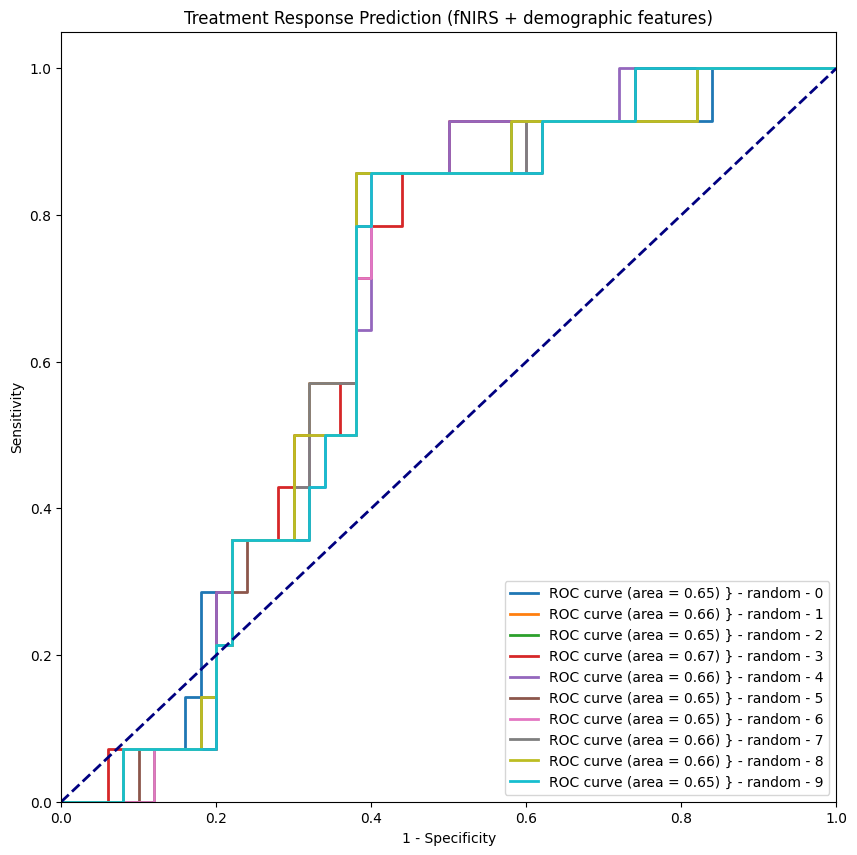

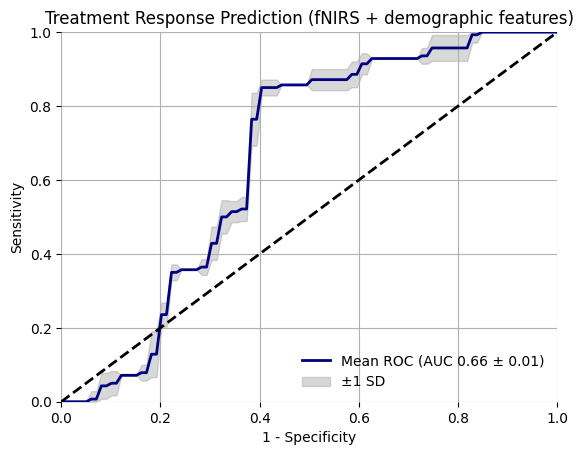

| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
|            | Balanced Accuracy | Sensitivity | Specificity | AUC | Balanced Accuracy | Sensitivity | Specificity | AUC |
| XGBoost   | 57.3714  | 52.1429  | 62.6000  | 65.6000  | 68.8878  | 69.5313  | 68.2444  | 68.8878  |

In [120]:

X_data = np.concatenate((pro_demographic, fnirs_feature), axis=1)
acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=10, title="Treatment Response Prediction (fNIRS + demographic features)", is_plotting_avg_auc=True)


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
TypeError: get_f1_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
TypeError: get_f1_score(

outer f1 ->  0.6430403556771546
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.6428571428571429 Specificity is 0.6 AUC is 0.7000000000000001
[0.64131944 0.65052083 0.63211806]


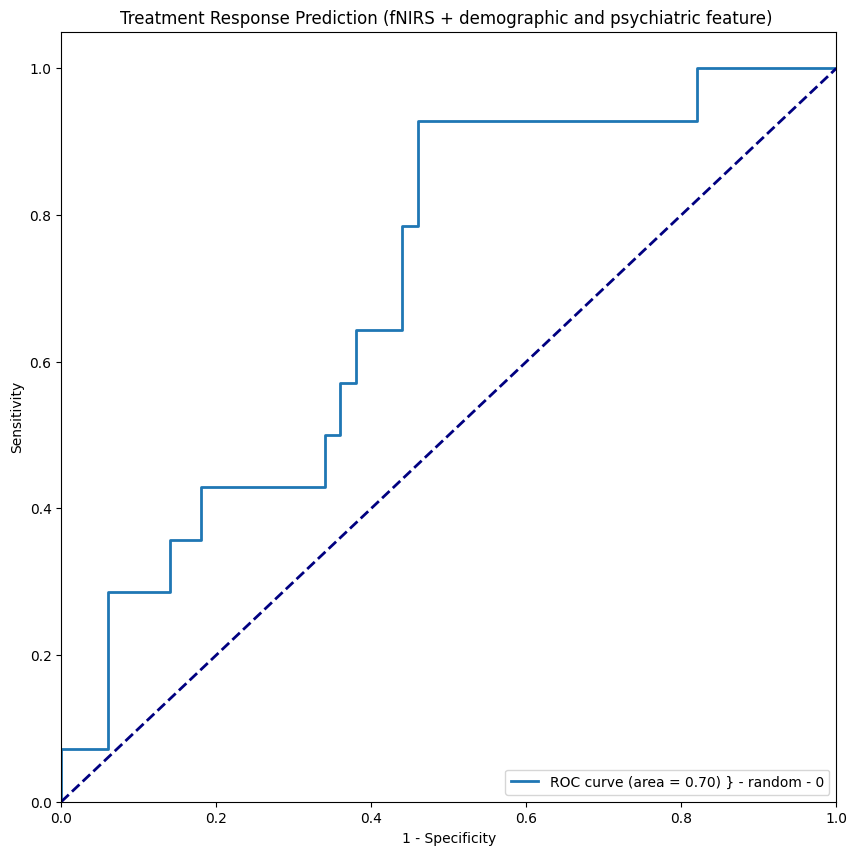

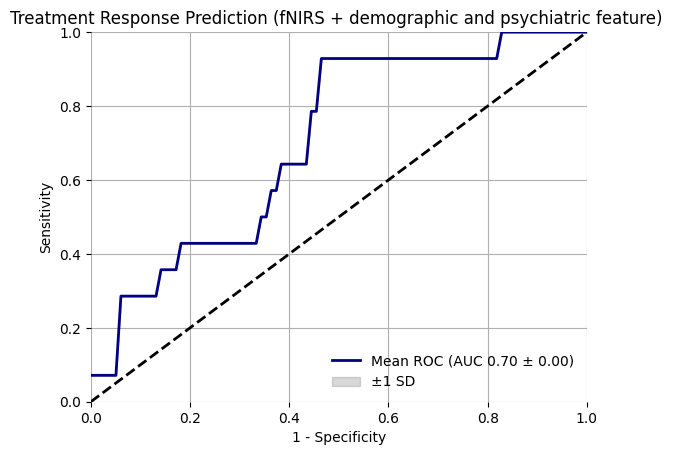

In [104]:
# for i in range(pro_pyschiatry.shape[1]):
X_data = np.concatenate((pro_pyschiatry[:,:9], pro_demographic, fnirs_feature), axis=1)
acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=1, title=f"Treatment Response Prediction (fNIRS + demographic and psychiatric feature) ", is_plotting_avg_auc=True)
    



In [ ]:
for i in range(1,pro_pyschiatry.shape[1]+1):
    Y = np.load(fold_path + '/label.npy', allow_pickle=True)
    X_replicated = np.concatenate((pro_pyschiatry[:, :i], 
                        pro_demographic,
                        fnirs_feature
                        ), axis=1)
    train_xgboost_shuffle_feature(X_replicated, Y, num_shuffle=1, msg=f'pyschiatry[:{i}]')

In [8]:
print(z_imputed_clinical_data.shape)
print(demographic_data.shape)
print(fnirs_prediction_all.shape)

X = np.concatenate((z_imputed_clinical_data, demographic_data, fnirs_feature), axis=1)

# np.save(fold_path + '/demo_11_cli_7_fnirs_1.npy', X)

(64, 7)
(64, 11)
(64, 1)


scaled by 1000000.0 Accuracy: 0.671875 Sensitivity is 0.5714285714285714 Specificity is 0.7
[0.71138889 0.78229167 0.64048611]
scaled by 1000000.0 Accuracy: 0.65625 Sensitivity is 0.5 Specificity is 0.7
[0.71475694 0.78385417 0.64565972]


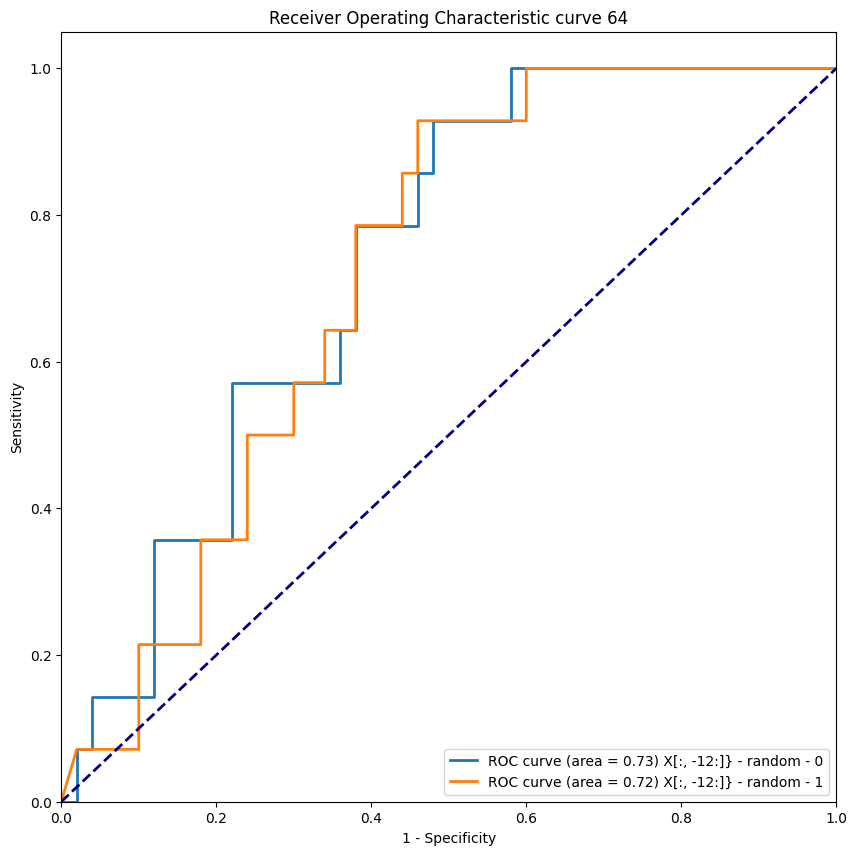

In [361]:
Y = np.load(fold_path + '/label.npy', allow_pickle=True)
feature_i = 11 # for feature_i in range(X.shape[1]):
train_xgboost_shuffle_feature(X[:, -feature_i-1:], Y)

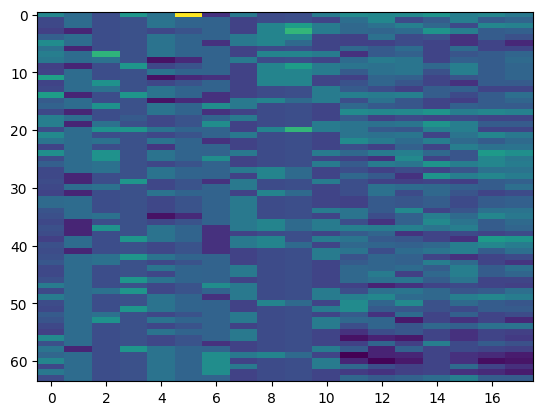

In [14]:
demo_cli_merge_data = np.concatenate((demographic_data, z_imputed_data), axis=1)
import matplotlib.pyplot as plt
plt.imshow(demo_cli_merge_data, aspect='auto')
np.save(fold_path + '/nor_demo_cli_merge_data.npy', demo_cli_merge_data)

In [25]:
combine = list(zip(demo_cli_merge_data, demo_cli_merge_data, demo_cli_merge_data))

import random
random.shuffle(combine)

a, b, c = zip(*combine)
print(a[0])
print(b[0])
print(c[0])


[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]
[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]
[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]


In [24]:


Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

In [26]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

X_train = X
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = CatBoostClassifier(verbose=0)

# 参数网格
param_grid = {
    'learning_rate': [1e-6],
    'depth': [4],
    'l2_leaf_reg': [5],
    'iterations': [100],
    'border_count': [32],


}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


ModuleNotFoundError: No module named 'catboost'

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


X_train = X
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = XGBClassifier(scale_pos_weight=61*1e5)

# 参数网格
# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [4],  # Depth of trees. Increasing this value will make the model more complex and more likely to overfit.
    'learning_rate': [0.01],  # Step size shrinkage used to prevent overfitting. Range is [0,1]
    'scale_pos_weight': [1e2],  # A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'scale_pos_weight': 100.0}
Best score: 1.0


In [30]:
demographic_data = np.load(fold_path + '/demografic_data.npy', allow_pickle=True)
demographic_data = demographic_data.astype(float)
demographic_data = np.nan_to_num(demographic_data, 0)
demographic_data = zscore(demographic_data, axis=0)
print(demographic_data)

[[ 1.54893332  0.52915026 -0.60535015  2.1665957   0.81749636  6.79962494
  -1.51102763  1.03175391 -0.67419986 -0.5400228   1.13389342]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337  1.4832397   2.50951771  1.13389342]
 [-1.05259005 -1.88982237 -0.60535015 -0.42521972 -0.80064077 -0.40961596
   0.1855648  -0.96922337  1.4832397   3.52603121  1.13389342]
 [ 0.04278821  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648   1.03175391  1.4832397   1.4930042  -0.8819171 ]
 [ 1.82277789  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
  -1.51102763  1.03175391  1.4832397   0.4764907  -0.8819171 ]
 [ 0.72739963 -1.88982237 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [ 1.27508876  0.52915026  3.40248531 -0.

model - CatBoost - metrics - {'bAcc': 0.6633333333333333, 'Sensitivity': 0.6666666666666666, 'Specificity': 0.6599999999999999}
model - XGBoost - metrics - {'bAcc': 0.6466666666666667, 'Sensitivity': 0.7333333333333333, 'Specificity': 0.5599999999999999}
model - RandomForest - metrics - {'bAcc': 0.6166666666666666, 'Sensitivity': 0.4333333333333333, 'Specificity': 0.8}
model - DecisionTree - metrics - {'bAcc': 0.5733333333333333, 'Sensitivity': 0.36666666666666664, 'Specificity': 0.78}
model - Support Vector - metrics - {'bAcc': 0.5, 'Sensitivity': 0.0, 'Specificity': 1.0}
model - NearestNeighbor - metrics - {'bAcc': 0.49000000000000005, 'Sensitivity': 0.0, 'Specificity': 0.9800000000000001}
model - Perceptron - metrics - {'bAcc': 0.48999999999999994, 'Sensitivity': 0.3, 'Specificity': 0.6799999999999999}


In [208]:
X.shape

8 - > 3 ->  7 1 

(64, 19)

scaled by 1000000.0 Accuracy: 0.671875 Sensitivity is 0.5714285714285714 Specificity is 0.7
[0.70984375 0.78125    0.6384375 ]
scaled by 1000000.0 Accuracy: 0.671875 Sensitivity is 0.5714285714285714 Specificity is 0.7
[0.71489583 0.78541667 0.644375  ]


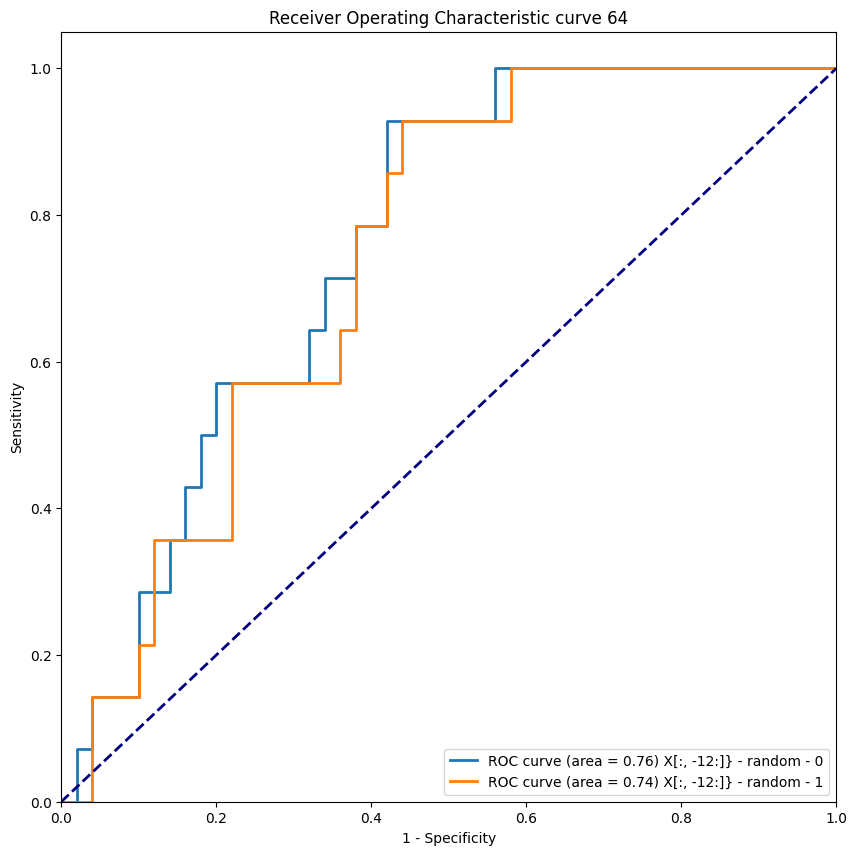

In [11]:
from sklearn.model_selection import LeaveOneOut, cross_validate, KFold, cross_val_predict
from sklearn.metrics import make_scorer, balanced_accuracy_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import numpy as np



    
Y = np.load(fold_path + '/label.npy', allow_pickle=True)
feature_i = 11 # for feature_i in range(X.shape[1]):
train_xgboost_shuffle_feature(X[:, -feature_i-1:], Y)

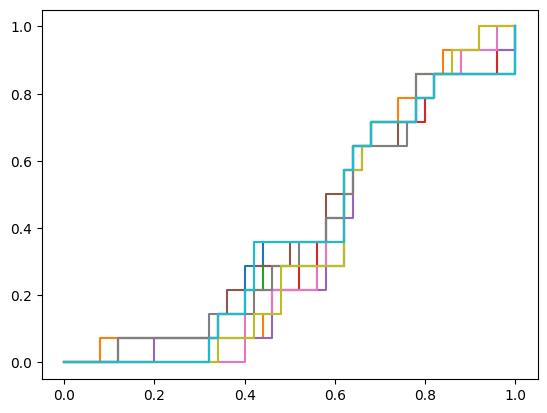

In [198]:
for i in all_fpr_tpr:
    plt.plot(i[0], i[1])

In [199]:
fprs = []
tprs = []
roc_aucs = []
for i in all_fpr_tpr:
    fprs.append(i[0])
    tprs.append(i[1])
    roc_aucs.append(auc(i[0], i[1]))

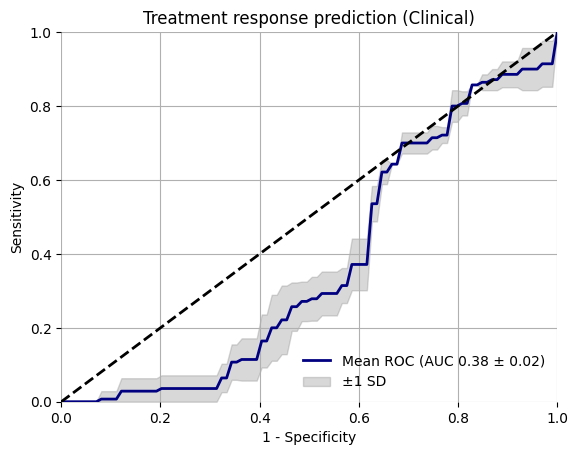

In [201]:

from scipy import interp





# plt.plot(mean_fpr, mean_tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

In [1]:
import matplotlib.pyplot as plt
fusion_data[:,-1:]

last_fusion_data = fusion_data[:,-1:].copy()
pos_las = last_fusion_data[Y_train == 1]
neg_las = last_fusion_data[Y_train == 0]
plt.hist(pos_las, bins=20, alpha=0.5, label='Positive')

plt.figure()
plt.hist(neg_las, bins=20, alpha=0.5, label='Negative')

NameError: name 'fusion_data' is not defined